In [1]:
from utils.CoopEnv import CoopEnv
from utils.IACagent import Agent

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# Set constant hyperparameters
n = 20
num_of_tasks  = 10
num_of_sims = 1
step_limit = 10000

In [4]:
lower_bound = -0.99
upper_bound = 2.00
comm_array = np.linspace(lower_bound, upper_bound, 300)

comm_space = len(comm_array)
print(comm_array)

[-0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93 -0.92 -0.91 -0.9  -0.89 -0.88
 -0.87 -0.86 -0.85 -0.84 -0.83 -0.82 -0.81 -0.8  -0.79 -0.78 -0.77 -0.76
 -0.75 -0.74 -0.73 -0.72 -0.71 -0.7  -0.69 -0.68 -0.67 -0.66 -0.65 -0.64
 -0.63 -0.62 -0.61 -0.6  -0.59 -0.58 -0.57 -0.56 -0.55 -0.54 -0.53 -0.52
 -0.51 -0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41 -0.4
 -0.39 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29 -0.28
 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16
 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04
 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08
  0.09  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2
  0.21  0.22  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32
  0.33  0.34  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44
  0.45  0.46  0.47  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56
  0.57  0.58  0.59  0.6   0.61  0.62  0.63  0.64  0.6

In [5]:
env = CoopEnv(n=n, num_of_tasks=num_of_tasks)

In [6]:
steps_to_complete = np.zeros((num_of_sims, step_limit+1))
comm_rec_actions = np.zeros((step_limit, env.n))
move_rec_actions = np.zeros((step_limit, env.n))

In [7]:
def main():

    for s in range(num_of_sims):

        print("----------------------------------")
        print(f"Starting training simulation {s}:")
        print("----------------------------------")

        # reinitialise agent list each sim
        agentlist = {i: Agent(comm_space) for i in range(env.n)}
        # reset the environment
        observations = env.reset(n=n, num_of_tasks =num_of_tasks )

        # begin training loop
        t = 0
        while t < step_limit:
            print(t, end='\r')

            sys_actions = np.zeros((env.n, 2)) # column 0 for move actions and column 1 for comm actions
            # collect move and comm  action for each agent
            sys_actions = np.array([agentlist[i].choose_action(observations[i]) for i in range(env.n)])

            action_move = sys_actions[:,0]
            action_comm = comm_array[sys_actions[:,1]]

            next_observations, rewards, termination, info = env.step(action_move, action_comm) # env.step

            comm_rec_actions[t] = action_comm  # output from actor (comm head)
            move_rec_actions[t] = action_move

            for i in range(env.n): # train each agent
                agentlist[i].train(observations[i], sys_actions[i, :], rewards[i], next_observations[i])

            # advance state
            observations = next_observations
            # record average system reward score
            steps_to_complete[s, t+1] = (sum(rewards)/env.n) + steps_to_complete[s, t]

            # increment timestep and loop
            t +=1


In [8]:
if __name__ == "__main__":

    #cProfile.run('main()')
    main()


----------------------------------
Starting training simulation 0:
----------------------------------


KeyboardInterrupt: 

In [ ]:
# save reward and actions
np.save(f'n{n}t{num_of_tasks}_cum_rew_bc', steps_to_complete)
np.save(f'n{n}t{num_of_tasks}_actions_bc', comm_rec_actions)

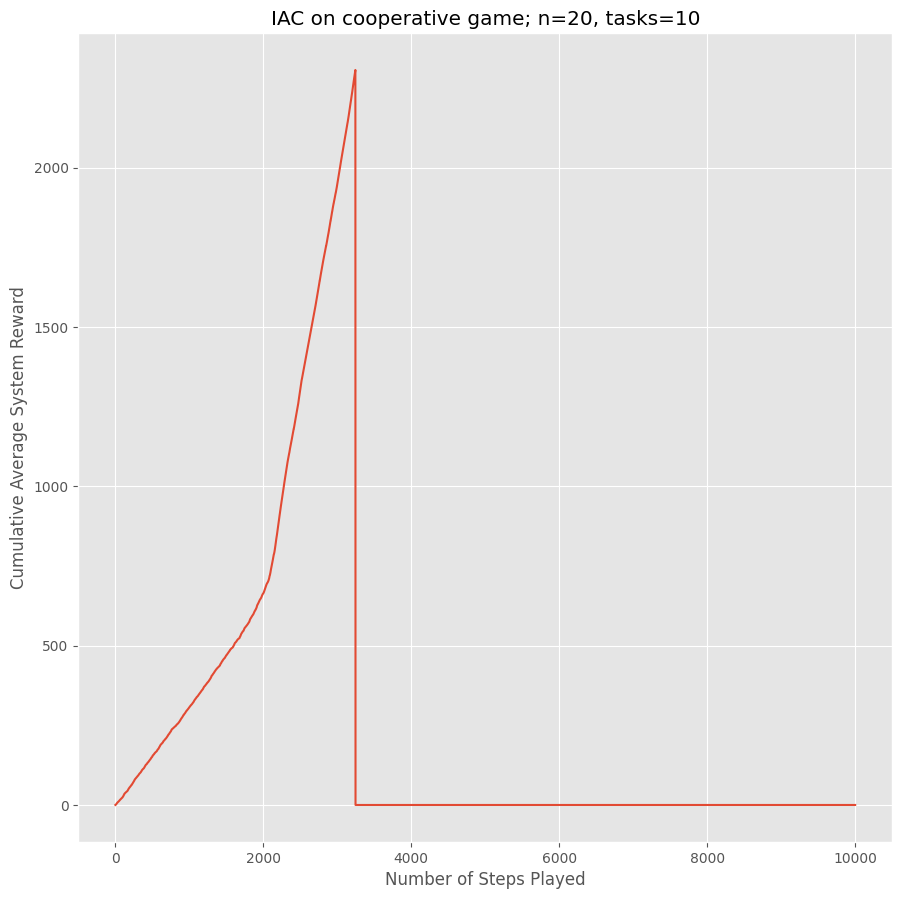

In [ ]:
plt.style.use('ggplot')
b = np.mean(steps_to_complete, axis=0)
s_dev = np.std(steps_to_complete, axis=0)
plt.xlabel('Number of Steps Played')
plt.ylabel('Cumulative Average System Reward')
plt.title(f'IAC on cooperative game; n={n}, tasks={num_of_tasks}')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.plot(b)

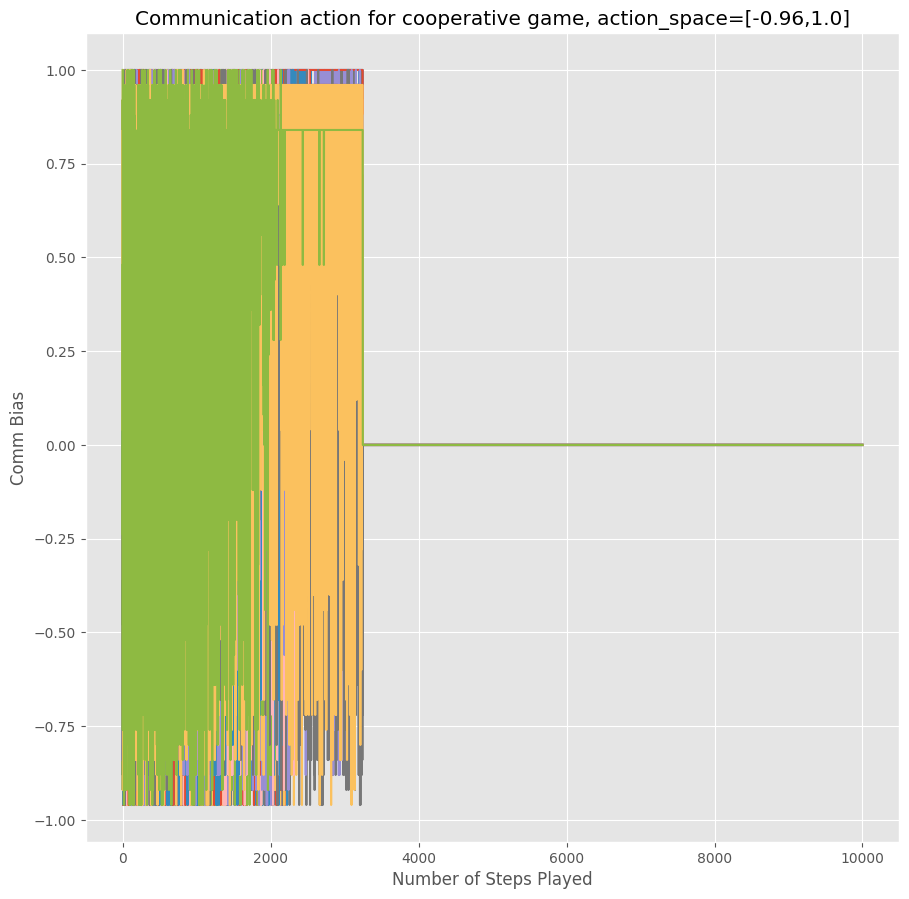

In [ ]:
plt.xlabel('Number of Steps Played')
plt.ylabel('Comm Bias')
plt.title(f'Communication action for cooperative game, action_space=[{lower_bound},{upper_bound}]')
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

plt.plot(comm_rec_actions)

In [ ]:
# Get coalition structure
converged_structure = np.zeros((num_of_tasks, env.n))
task = 0
for C in env.CS:
    indices = [int(a)-1 for a in list(C)]
    converged_structure[task, indices] = 1
    task+=1

print(converged_structure)
np.save(f'n{n}t{num_of_tasks}_cstruct_cnf0.npy', converged_structure)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]]


In [ ]:
print(env.CS)

[set(), set(), {'4', '18'}, set(), {'16'}, {'2', '6', '20', '9', '5', '13', '10', '14', '12', '11', '8', '7', '3'}, {'19', '1'}, set(), set(), {'17', '15'}]
